In [1]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def psnr(original, decoded):
    mse = np.mean(np.power(original - decoded, 2))
    if(mse == 0):
        return np.inf
    max_val = 255.0
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

In [3]:
model_name = "default"

my_coords = {}
jpg_coords = {}

filenames = ["lena", "baboon", "peppers"]

for filename in filenames:
    my_coords[filename] = []
    for B in [1, 2, 4, 6]:
        image_path = fr"compression-lab-imgs\{filename}.png"
        encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape[:2])

        !python encode.py -i {image_path} -B {B} -s {compressor_state_path} -o {encode_output_path} -m {model_name}
        !python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

        my_img_np = skimage.io.imread(decode_output_path)
        my_psnr = psnr(orig_img_np, my_img_np)
        my_bpp = os.path.getsize(encode_output_path) * 8 / n_pixels
        my_coords[filename].append((my_bpp, my_psnr))


    jpg_coords[filename] = []
    orig_img = Image.fromarray(orig_img_np)
    jpg_qualities = [10, 25, 45, 75] if filename == 'baboon' else [30, 60, 70, 90]
    for jpg_quality in jpg_qualities:
        jpg_path = fr"compression-lab-imgs\{filename}_q{jpg_quality}.jpg"
        orig_img.save(jpg_path, "JPEG", quality=jpg_quality, optimize=True, progressive=True)
        
        jpg_np = skimage.io.imread(jpg_path)
        jpg_psnr = psnr(orig_img_np, jpg_np)
        jpg_bpp = os.path.getsize(jpg_path) * 8 / n_pixels
        jpg_coords[filename].append((jpg_bpp, jpg_psnr))

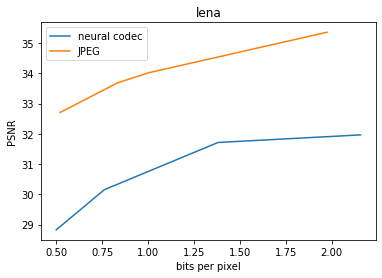

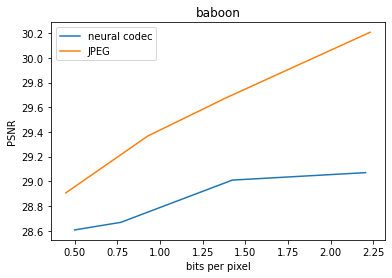

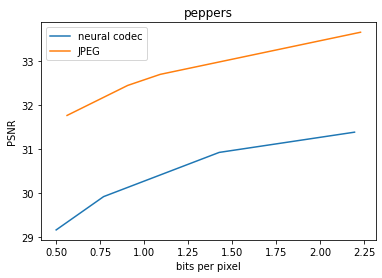

In [4]:
for filename in filenames:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(filename)
    ax.set_xlabel('bits per pixel')
    ax.set_ylabel('PSNR')
    plt.plot(*list(zip(*my_coords[filename])))
    plt.plot(*list(zip(*jpg_coords[filename])))
    ax.legend(["neural codec", "JPEG"])
    plt.show()

In [5]:
my_coords

{'lena': [(0.500030517578125, 28.8262232887743),
  (0.76202392578125, 30.153900287554695),
  (1.38140869140625, 31.715522356564993),
  (2.15753173828125, 31.96545877467754)],
 'baboon': [(0.500030517578125, 28.606871343305503),
  (0.7708740234375, 28.668292443096945),
  (1.42352294921875, 29.010078956086097),
  (2.203857421875, 29.070419974335277)],
 'peppers': [(0.500030517578125, 29.170981302604552),
  (0.7694091796875, 29.92644229425872),
  (1.426055908203125, 30.92931818269031),
  (2.19476318359375, 31.388472195929694)]}

In [7]:
jpg_coords

{'lena': [(0.521026611328125, 32.705530811829455),
  (0.835540771484375, 33.68852107075787),
  (1.005584716796875, 34.021802165263736),
  (1.975494384765625, 35.35724122997543)],
 'baboon': [(0.44830322265625, 28.906541518277553),
  (0.92791748046875, 29.366362029740117),
  (1.389862060546875, 29.677886088213604),
  (2.23095703125, 30.20682970927162)],
 'peppers': [(0.561798095703125, 31.76813141238712),
  (0.90631103515625, 32.448936817064464),
  (1.09112548828125, 32.69988326299634),
  (2.228851318359375, 33.65550539396375)]}

In [8]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

from looseless_compressors import Huffman 

from decoder_pipeline import (decoder_pipeline,
                              get_quant_error_normal,
                              get_zero_noise,
                              get_quant_error_uniform)

from trained_models import get_decoder

from encoder_pipeline import encoder_pipeline
from trained_models import get_encoder





from typing import List
import os

import torch
import numpy as np
from PIL import Image

from trained_models import get_decoder
from looseless_compressors import LooselessCompressor, Huffman
from decoder_pipeline import denormalize_imagenet, decode_binary_file, torch_img_to_np_img

In [12]:
def test_quantization_and_noise(model_name, filename, B_list, get_noise, quantize: bool, title):
    for B in B_list:
        image_path = fr"compression-lab-imgs\{filename}.png"
        # encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        # compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        # decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape[:2])
        looseless_compressor = Huffman()

        encoder = get_encoder(model_name, B)
        encoder_out, binary_string = encoder_pipeline(
            encoder, image_path, B,
            compressor_state_path = None,
            compressed_img_path = None,
            looseless_compressor = looseless_compressor)

        decoder = get_decoder(model_name, B)
        decoder.eval()

        if quantize:
            binary_list = looseless_compressor.decode(binary_string)
            quantized = torch.tensor(binary_list)
            dequantized = quantized / 2**B
            height = width = int((len(dequantized)/decoder.in_channels)**0.5)

            decoder_input = dequantized.reshape(
                1, decoder.in_channels, height, width)
        else:
            decoder_input = encoder_out

        decoded_tensor_imagenet_norm = decoder(
            decoder_input + get_noise(decoder_input.shape, B))

        decoded_tensor = denormalize_imagenet(
            decoded_tensor_imagenet_norm.squeeze(0))
        
        my_img_np = torch_img_to_np_img(decoded_tensor)

        my_psnr = psnr(orig_img_np, my_img_np)
        # my_bpp = os.path.getsize(encode_output_path) / n_pixels
        # Since last bit is always 1 (it's seq_end indicator) we remove it.
        my_bpp = len(binary_string[:-1]) / n_pixels

        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        ax.set_title(f"{title}\nB = {B}, psnr = {my_psnr:.3f}, bpp = {my_bpp:.3f}")
        plt.imshow(my_img_np)
        plt.axis('off')

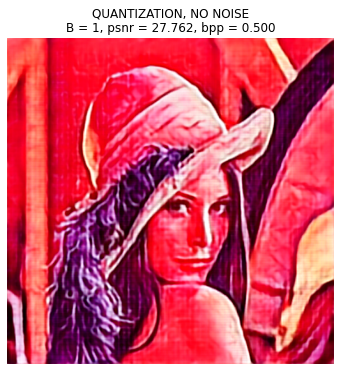

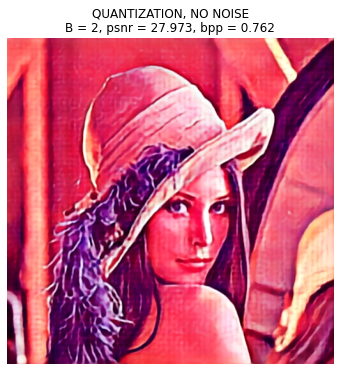

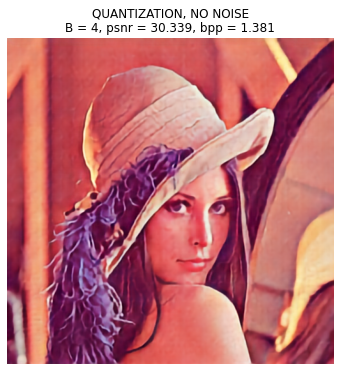

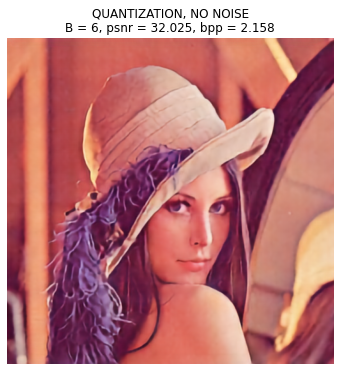

In [13]:
test_quantization_and_noise(model_name = "default", filename="lena",
                            B_list = [1, 2, 4, 6], get_noise=get_zero_noise,
                            quantize=True, title = "QUANTIZATION, NO NOISE")

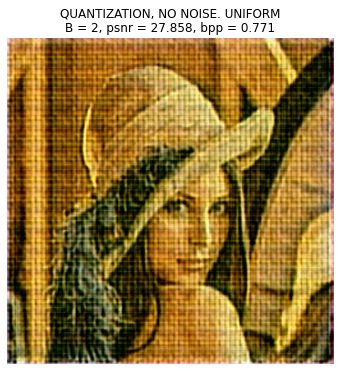

In [14]:
test_quantization_and_noise(model_name = "resnet18x32__512ch__abs__relu__no_last_activation__uniform_noise",
                            filename="lena", B_list = [2], get_noise=get_zero_noise,
                            quantize=True, title = "QUANTIZATION, NO NOISE. UNIFORM")

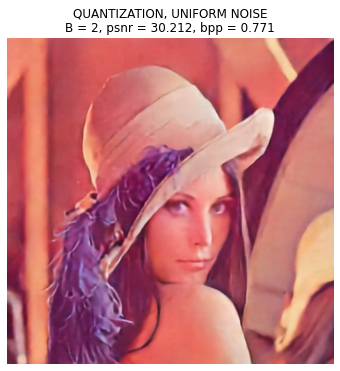

In [15]:
test_quantization_and_noise(model_name = "resnet18x32__512ch__abs__relu__no_last_activation__uniform_noise",
                            filename="lena", B_list = [2], get_noise=get_quant_error_uniform,
                            quantize=True, title = "QUANTIZATION, UNIFORM NOISE")

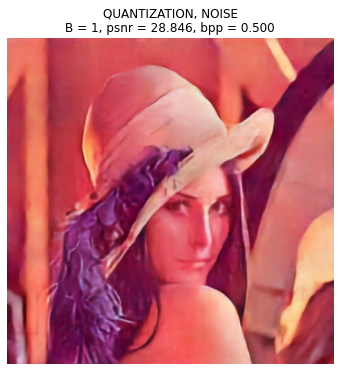

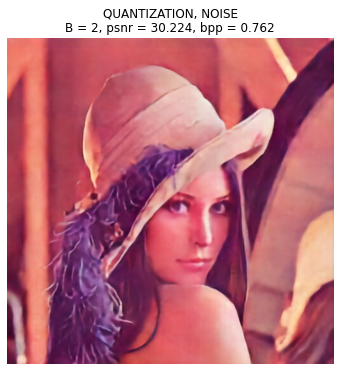

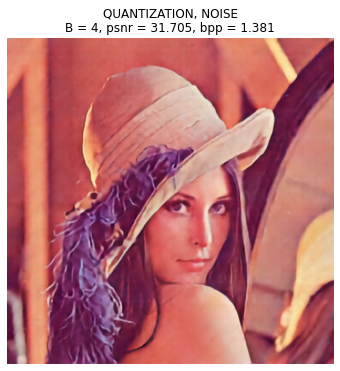

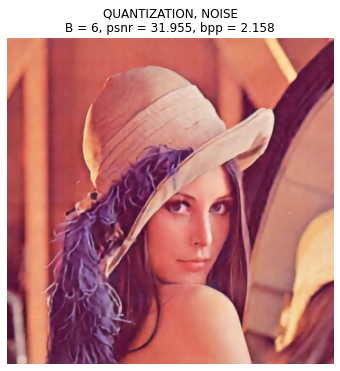

In [17]:
test_quantization_and_noise(model_name = "default",
                            filename="lena",
                            B_list = [1, 2, 4, 6],
                            get_noise=get_quant_error_normal,
                            quantize=True,
                            title = "QUANTIZATION, NOISE")

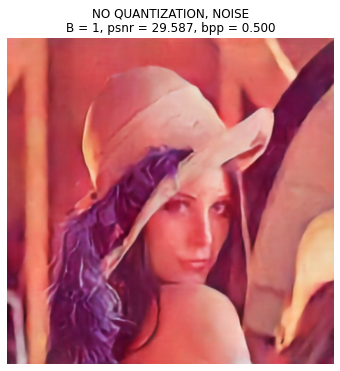

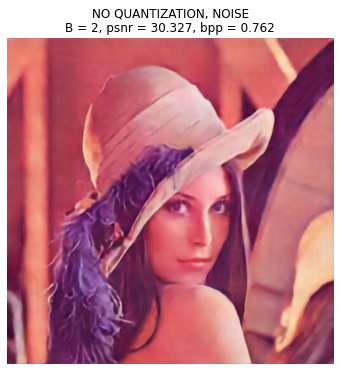

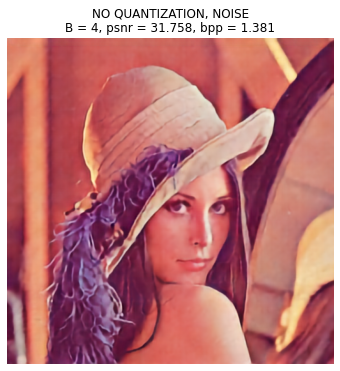

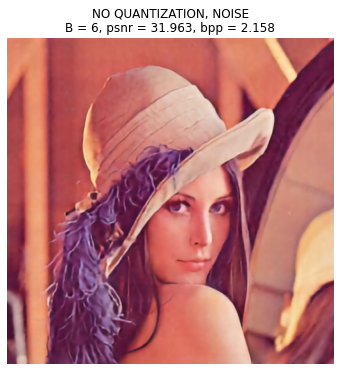

In [18]:
test_quantization_and_noise(model_name = "default",
                            filename="lena",
                            B_list = [1, 2, 4, 6],
                            get_noise=get_quant_error_normal,
                            quantize=False,
                            title = "NO QUANTIZATION, NOISE")

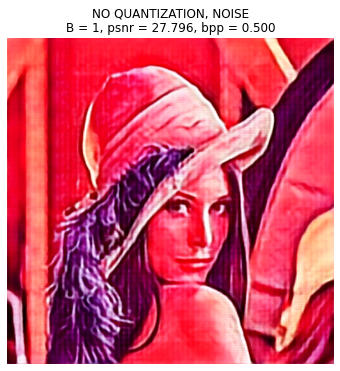

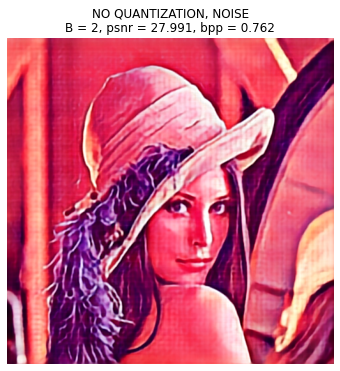

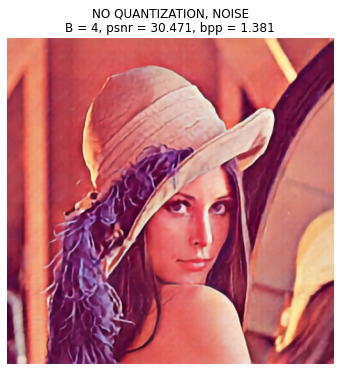

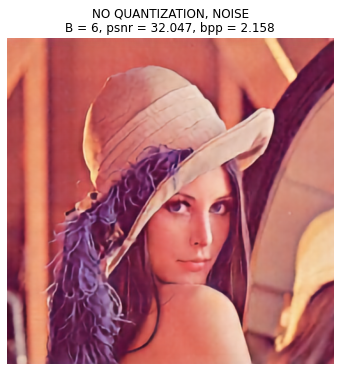

In [19]:
test_quantization_and_noise(model_name = "default",
                            filename="lena",
                            B_list = [1, 2, 4, 6],
                            get_noise=get_zero_noise,
                            quantize=False,
                            title = "NO QUANTIZATION, NOISE")